# Inter-arrival times between NXDs 

In [2]:
import csv
import json
import ast
import statistics
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

X = []
y = []
c = 1
family_to_label = {}
label_to_family = {}
indx = 1

                
# load valid TLDs
dataset_dir = Path("../5. Evaluation/5.1. Dataset/")
valid_tlds = []
tld_fname = dataset_dir / "tlds-alpha-by-domain.txt"
with open(tld_fname) as f_r:
    i = 0
    for l in f_r:
        if i == 0:
            i = 1
            continue
        valid_tlds.append(l.lower().strip())
        
tld_to_int = {}
i = 1
for tld in valid_tlds:
    if tld not in tld_to_int:
        tld_to_int[tld] = i
        i += 1

def qname_features(qname):
    dml = len(qname) - qname.count(".") # domain name length
    sub_domains = qname.split(".") 
    nb_sub_d = len(sub_domains) - 1 # number of subdomains
    tld = sub_domains[len(sub_domains)-1] # is valid tld

    is_valid_tld = 0 # is valid tld
    tld_indx = 0 # tld index (if valid)
    
    if tld in valid_tlds:
        is_valid_tld = 1
        tld_indx = tld_to_int[tld]
    else:
        is_valid_tld = 0

    has_single_sub_d = 0 # has a single subdomain
    for indx in range(len(sub_domains)-1):
        if len(sub_domains[indx]) == 1:
            has_single_sub_d = 1
            break
            
    nb_underscores = qname.count("_") # number of underscores


    bigram_score = bigram_p4.get_ngram(qname, combined_bigram_scores)                   
    trigram_score = trigram_p4.get_ngram(qname, combined_trigram_scores)
    

    returned_fts = {}
    returned_fts['bigram_score'] = bigram_score
    returned_fts['trigram_score'] = trigram_score
    returned_fts['dml'] = dml
    returned_fts['nb_sub_d'] = nb_sub_d
    returned_fts['is_valid_tld'] = is_valid_tld
    returned_fts['has_single_sub_d'] = has_single_sub_d
    returned_fts['tld'] = tld_indx

    return returned_fts


def features_dict_to_ls (features: str) -> list:
    '''
        Arguments:
            features: string of features  {'unique_ip_reqs':0, 'dns_reqs':0, ...}
        Returns:
            a list of the feauters' values (context-aware and context-less)
    '''
    global context_aware_fts
    global context_less_fts
    
    features = features.replace("Decimal('", "")
    features = features.replace("')", "")
    
    try:
        features = json.loads(features)
        features = ast.literal_eval(features)
    except:
        return [-1]
    
    if features['nxd_qname'] == "":
        return [-1]
    
    qname = features['nxd_qname']
    qname_ft = qname_features(qname)
    
    ls = []
    
    # context-aware features
    dns_reqs = 1
    ip_reqs = 1
    for ft in context_aware_fts:
        try:    
            ls.append(features[ft])
        except:
            continue
        
    # context-less features
    for ft in context_less_fts:
        ls.append(qname_ft[ft])

    return [ls, features]
    

def load_events_dataset(csvfile_name: str, traffic_type: str) -> (list, list):
    all_nxd_iarrivals = {}
    with open(csvfile_name, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        row_indx = 0
        for row in reader:
            row_indx += 1

            if row[2] == '8.8.8.8':
                continue

            if traffic_type == "CTU": # benign
                start_col = 3
                family = 'benign'
                if len(row) <= 3:
                    continue
            elif traffic_type == "DGA":
                start_col = 4
                family = row[0]
                
                if len(row) <= 4:
                    continue    
                    
            if family not in all_nxd_iarrivals:
                all_nxd_iarrivals[family] = []
                
            curr_nxd_iarrivals = []
            for col_indx in range(start_col, len(row)):
                curr_col = row[col_indx]
                features = "\"" + curr_col + "\""
                features = features.replace("Decimal('", "")
                features = features.replace("')", "")
                try:
                    features = json.loads(features)
                    features = ast.literal_eval(features)
                    nxd_iarrival = features['nxd_iarrival']
                    curr_nxd_iarrivals.append(nxd_iarrival)
                except:
                    print("\t\t", row_indx, col_indx, csvfile_name )
                
            avg_nxd_iarrivals = sum(curr_nxd_iarrivals) / len(curr_nxd_iarrivals)
            all_nxd_iarrivals[family].append(avg_nxd_iarrivals)

    return all_nxd_iarrivals




# CTU traffic

In [4]:
X = [] 
y1 = []
y2 = []
data_ctu = {}
for i in range(42, 55): # 42, 55 !!! 
    ctu_fname = "data_no_infection_dns-" + str(i) + "_4.csv"
    ctu_rel_path = dataset_dir / "normal_ctu" / ctu_fname
    all_nxd_iarrivals = load_events_dataset(ctu_rel_path, traffic_type="CTU")
    all_nxd_iarrivals = all_nxd_iarrivals['benign']
    x = "       CTU-" + str(i)
    median = statistics.median(all_nxd_iarrivals)
    mean = statistics.mean(all_nxd_iarrivals)
    data_ctu[x] = {"Mean": mean, "Median": median}
    
    print(ctu_rel_path)
    print("\t", statistics.median(all_nxd_iarrivals), statistics.mean(all_nxd_iarrivals))
    

../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-42_4.csv
	 63.02514091111111 559.71004531916
../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-43_4.csv
	 251.26819908333326 593.4201246311102
../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-44_4.csv
	 505.1375414952381 9720.91111989408
		 171 3 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 4 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 5 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 6 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 7 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 8 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 9 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 10 ../5. Evaluation/5.1. Dataset/normal_ctu/data_no_infection_dns-45_4.csv
		 171 11 ../5. Evaluat

# DGA traffic

In [5]:
dga_rel_path =  dataset_dir / "DGA" / "trans_icc_newft.csv"
all_nxd_iarrivals = load_events_dataset(dga_rel_path, traffic_type="DGA")
data_dgas = {}
for family, nxd_iarrivals in all_nxd_iarrivals.items():
    mean = sum(nxd_iarrivals)/len(nxd_iarrivals)
    median = sum(nxd_iarrivals)/len(nxd_iarrivals)
    data_dgas[family] = {"Mean": mean, "Median": median}
    print(family, mean, median)
    

cutwail 113.34036163131313 113.34036163131313
ursnif 113.11881199034462 113.11881199034462
xblocker 1.8114170217536816 1.8114170217536816
qadars 0.6444583581126074 0.6444583581126074
diamondfox 9.07626073170045 9.07626073170045
zloader 9.790345050818827 9.790345050818827
locky 37.13665226269157 37.13665226269157
suppobox 1.635067476868911 1.635067476868911
pushdo 5.397027911257178 5.397027911257178
necurs 0.7899279698233881 0.7899279698233881
nymaim 1.7263565260293745 1.7263565260293745
pykspa 4.090287711843311 4.090287711843311
simda 0.6309943973322033 0.6309943973322033
tinba 6.77586059274016 6.77586059274016
dircrypt 0.9171352820439344 0.9171352820439344
qsnatch 153.83020248611112 153.83020248611112
gozi 71.70075272727273 71.70075272727273
murofet 1.7982862065548781 1.7982862065548781
phorpiex 5.840598477787136 5.840598477787136
gameover 2.28587046582343 2.28587046582343
tofsee 41.58857780535715 41.58857780535715
murofetweekly 3.921196497802899 3.921196497802899
mydoom 3.17031825444

# Plotting CTU alone

<Figure size 600x400 with 0 Axes>

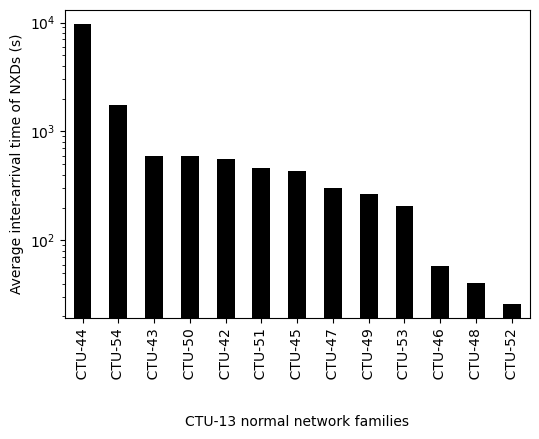

In [7]:
from matplotlib.pyplot import figure


fig = plt.figure(figsize=(6, 4))

df = pd.DataFrame(data_ctu)
df = df.T
df ['sum'] = df.sum(axis=1)
df.sort_values('Mean', ascending=False)[['Mean']].plot.bar(color=['black', 'tab:grey'], figsize=(6, 4), legend=False)

# plt.ylim([0, 2000])
plt.yscale("log")

plt.xlabel("CTU-13 normal network families")
plt.ylabel("Average inter-arrival time of NXDs (s)")
plt.title("")
plt.savefig('CTU_iarrivals2.pdf', bbox_inches = 'tight')
plt.show()

# Plotting DGAs alone

{'dyre': 0.0, 'hesperbot': 0.0, 'pandabanker': 0.0, 'shifu': 0.0, 'wd': 0.0, 'padcrypt': 0.06374969857357357, 'banjori': 0.09121151552287597, 'bamital': 0.1095105, 'bedep': 0.11692839230769231, 'makloader': 0.14031087109375, 'beebone': 0.1426415762876582, 'feodo': 0.46797218533817564, 'simda': 0.6309943973322033, 'qadars': 0.6444583581126074, 'corebot': 0.7155787397035841, 'necurs': 0.7899279698233881, 'dircrypt': 0.9171352820439344, 'chinad': 1.2629798653522077, 'ranbyus': 1.5307375687012985, 'nymaim2': 1.571547363783161, 'suppobox': 1.635067476868911, 'nymaim': 1.7263565260293745, 'murofet': 1.7982862065548781, 'xblocker': 1.8114170217536816, 'ramnit': 1.8672967422592015, 'cryptolocker': 1.8910725572210991, 'gameover': 2.28587046582343, 'emotet': 2.316726, 'tsifiri': 2.543470952380953, 'fobber': 2.5575897204968943, 'mydoom': 3.1703182544404394, 'vidrotid': 3.3591622429378534, 'murofetweekly': 3.921196497802899, 'pykspa': 4.090287711843311, 'pykspa2': 4.153189209616597, 'pykspa2s': 4.

<Figure size 800x400 with 0 Axes>

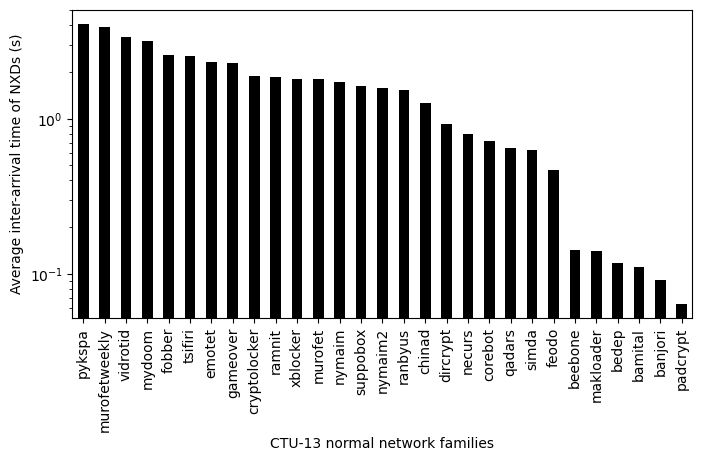

In [8]:
# lowest N_DGAs
N = 30
all_means = {}
for family, res in data_dgas.items():
    all_means[family] = res['Mean']
  

all_means_sorted = {k: v for k, v in sorted(all_means.items(), key=lambda item: item[1])}
lowest_N = []
i = 1
for family, v in all_means_sorted.items():
    if v == 0:
        continue
    lowest_N.append(family)
    i += 1
    if i == N:
        break
print(all_means_sorted)
print(lowest_N)

data_dgas_N = {}
for e, v in data_dgas.items():
    if e in lowest_N:
        data_dgas_N[e] = v

fig = plt.figure(figsize=(8, 4))

df = pd.DataFrame(data_dgas_N)
df = df.T
df ['sum'] = df.sum(axis=1)
df.sort_values('Mean', ascending=False)[['Mean']].plot.bar(color=['black', 'tab:grey'], figsize=(8, 4), legend=False)
# plt.ylim([0, 2000])
plt.yscale("log")

plt.xlabel("CTU-13 normal network families")
plt.ylabel("Average inter-arrival time of NXDs (s)")
plt.title("")
plt.savefig('DGA_iarrivals2.pdf', bbox_inches='tight' )
plt.show()